# Sampling image locations

In [1]:
import csv
import os
import random
import shutil
import osmnx as ox
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import LineString

C:\Users\win10\.conda\envs\yyjj125\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [7]:
import networkx as nx

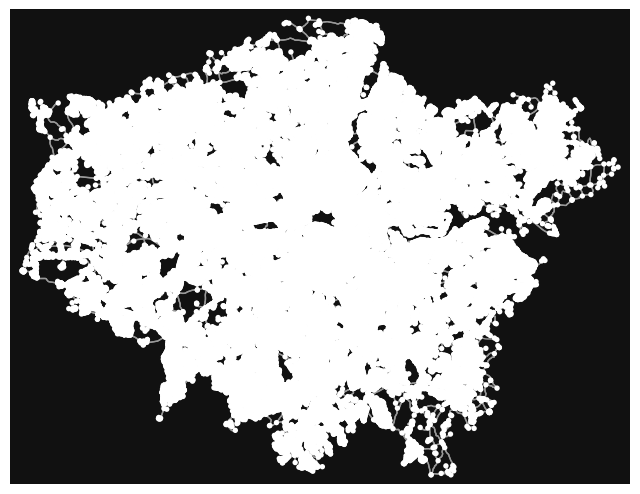

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [2]:
# street network for London
G=ox.graph_from_place('London,UK',network_type='drive')
ox.plot_graph(G)

In [3]:
# check how many edges
print(len(G.edges))

298630


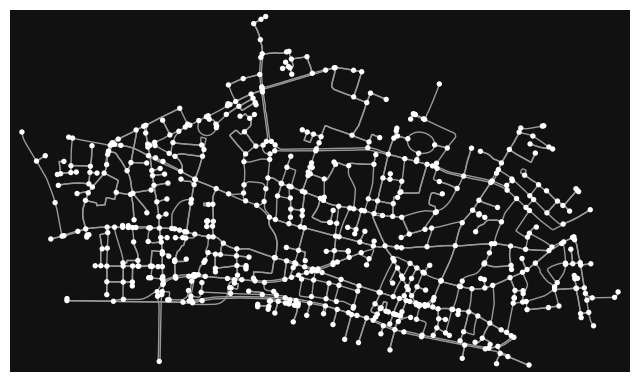

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [4]:
# city of London street network because London don't include this 
G2=ox.graph_from_place('City of London,UK',network_type='drive')
ox.plot_graph(G2)

In [5]:
# check how many edges in city of London
print(len(G2.edges))

1407


In [8]:
# merge G to make Inner London G
G_merge = nx.compose(G, G2)

In [ ]:
# list for saving all sampling points
sample_locations = []

In [6]:
# iterate all edges in G
for i, j, z, data in G.edges(keys=True, data=True):
    if 'geometry' in data and isinstance(data['geometry'], LineString):
        xs, ys = zip(*data['geometry'].coords)
    else:
        x1, y1 = G.nodes[i]['x'], G.nodes[i]['y']
        x2, y2 = G.nodes[j]['x'], G.nodes[j]['y']
        xs, ys = [x1, x2], [y1, y2]
    # calculate the middle point
    xs_sample = (xs[0] + xs[1]) / 2
    ys_sample = (ys[0] + ys[1]) / 2
    sample_locations.append((xs_sample, ys_sample))   
print(len(sample_locations), 'sample locations')

298235 sample locations


In [7]:
# iterate all edges in G2
for i, j, z, data in G2.edges(keys=True, data=True):
    if 'geometry' in data and isinstance(data['geometry'], LineString):
        xs, ys = zip(*data['geometry'].coords)
    else:
        x1, y1 = G.nodes[i]['x'], G.nodes[i]['y']
        x2, y2 = G.nodes[j]['x'], G.nodes[j]['y']
        xs, ys = [x1, x2], [y1, y2]
    # calculate the middle point
    xs_sample = (xs[0] + xs[1]) / 2
    ys_sample = (ys[0] + ys[1]) / 2
    sample_locations.append((xs_sample, ys_sample))
print(len(sample_locations), 'sample locations')

299667 sample locations


In [8]:
# remove duplicates
sample_locations = list(set(sample_locations))
print(len(sample_locations), 'sample locations')

259382 sample locations


In [ ]:
with open('before_smaple.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['lat', 'lon'])
    for location in sample_locations:
        writer.writerow([location[1], location[0]])

# plot all points and sampling

In [11]:
Sample = pd.read_csv('before_smaple.csv')

In [12]:
geometry = gpd.points_from_xy(Sample['lon'], Sample['lat'])
gdf = gpd.GeoDataFrame(Sample, geometry=geometry)

gdf

lat       lon                   geometry
0       51.448904 -0.191496  POINT (-0.19150 51.44890)
1       51.431733  0.016274   POINT (0.01627 51.43173)
2       51.494720  0.116618   POINT (0.11662 51.49472)
3       51.337493 -0.108552  POINT (-0.10855 51.33749)
4       51.441404  0.083061   POINT (0.08306 51.44140)
...           ...       ...                        ...
259377  51.353020 -0.151948  POINT (-0.15195 51.35302)
259378  51.502053 -0.080973  POINT (-0.08097 51.50205)
259379  51.548211 -0.146055  POINT (-0.14606 51.54821)
259380  51.383382  0.117686   POINT (0.11769 51.38338)
259381  51.553443  0.084418   POINT (0.08442 51.55344)

[259382 rows x 3 columns]

In [13]:
# set crs
gdf = gdf.set_crs(epsg=4326)
gdf = gdf.to_crs(epsg=3857)

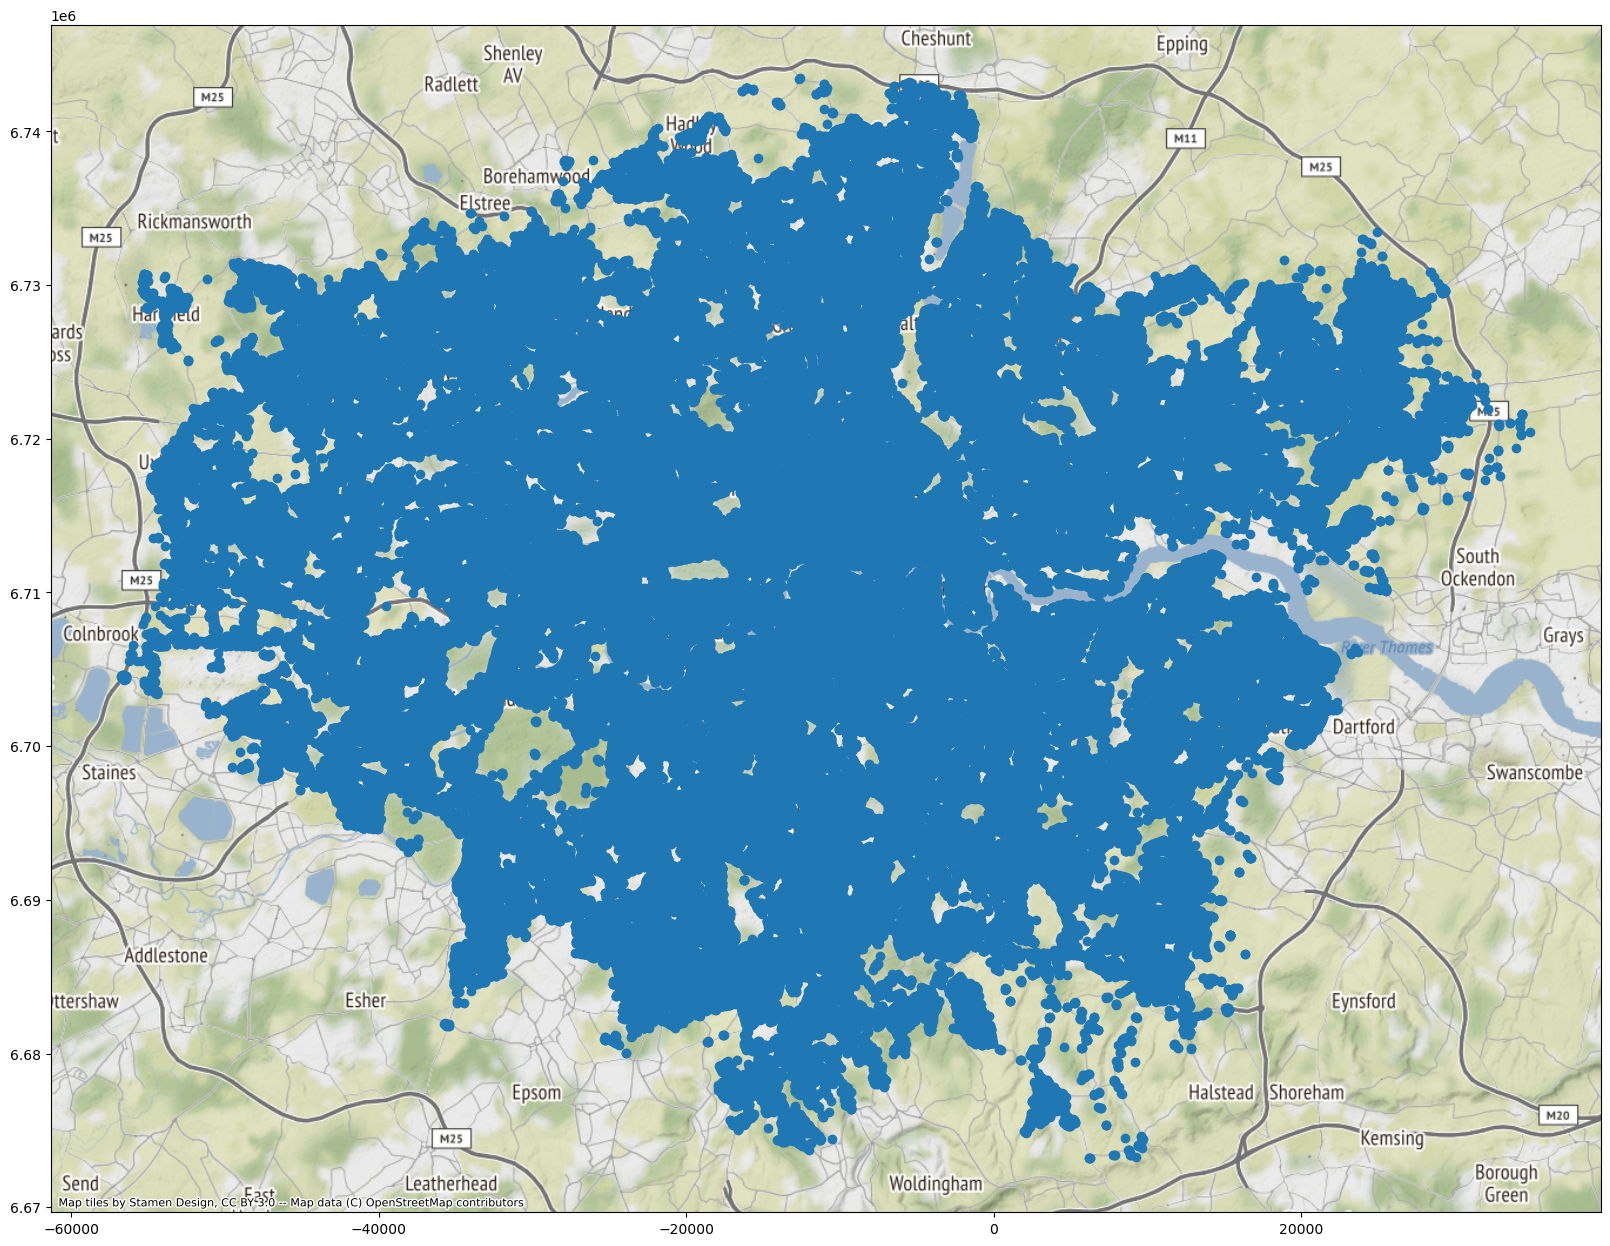

In [14]:
# plot all points
import contextily as cx
ax = gdf.plot(figsize=(20,20))
cx.add_basemap(ax, crs=gdf.crs.to_string())

In [9]:
# read LSOA shapefile
gdf2=gpd.read_file('ESRI/LSOA_2011_London_gen_MHW.shp')

In [16]:
# change crs
gdf2 = gdf2.to_crs(epsg=3857)

In [17]:
# check column names
gdf2.columns

Index(['LSOA11CD', 'LSOA11NM', 'MSOA11CD', 'MSOA11NM', 'LAD11CD', 'LAD11NM',
       'RGN11CD', 'RGN11NM', 'USUALRES', 'HHOLDRES', 'COMESTRES', 'POPDEN',
       'HHOLDS', 'AVHHOLDSZ', 'geometry'],
      dtype='object')

In [20]:
# saptial join 
points_with_lsoa = gpd.sjoin(gdf, gdf2, how="inner", predicate='intersects')

In [21]:
points_with_lsoa.shape

(259356, 18)

In [22]:
# check how many lsoa have points
unique_counts = points_with_lsoa['LSOA11CD'].nunique()
print(unique_counts)

4833


In [23]:
# check number of points in each lsoa
counts = points_with_lsoa.groupby('LSOA11CD').size().sort_values()

print(counts)
counts

LSOA11CD
E01033487      1
E01002004      1
E01032775      1
E01004739      2
E01000584      2
            ... 
E01000092    306
E01004736    307
E01033583    360
E01002444    505
E01032739    765
Length: 4833, dtype: int64


LSOA11CD
E01033487      1
E01002004      1
E01032775      1
E01004739      2
E01000584      2
            ... 
E01000092    306
E01004736    307
E01033583    360
E01002444    505
E01032739    765
Length: 4833, dtype: int64

In [42]:
def sample_points_in_lsoa(df):
    # If more than 5, randomly sample 5 
    if len(df) > 5:
        return df.sample(n=5, random_state=66)
    # if less than 5, keep all 
    else:
        return df

In [43]:
sample_points = points_with_lsoa.groupby('LSOA11CD').apply(sample_points_in_lsoa)

In [44]:
sample_points.reset_index(drop=True, inplace=True)

In [45]:
sample_points=sample_points.reset_index()

In [46]:
sample_points = sample_points.rename(columns={'index': 'PointID', 'index_right': 'index_LSOA'})

In [47]:
sample_points

PointID        lat       lon                        geometry  \
0            0  51.515956 -0.095641  POINT (-10646.752 6713072.791)   
1            1  51.517674 -0.096428  POINT (-10734.316 6713380.255)   
2            2  51.515767 -0.095506  POINT (-10631.646 6713039.062)   
3            3  51.520192 -0.097410  POINT (-10843.687 6713830.708)   
4            4  51.517899 -0.097043  POINT (-10802.805 6713420.515)   
...        ...        ...       ...                             ...   
24130    24130  51.474378 -0.013933   POINT (-1551.020 6705638.541)   
24131    24131  51.474041 -0.011340   POINT (-1262.324 6705578.312)   
24132    24132  51.476282 -0.013850   POINT (-1541.825 6705978.951)   
24133    24133  51.473442 -0.013688   POINT (-1523.702 6705471.313)   
24134    24134  51.474096 -0.011071   POINT (-1232.457 6705588.115)   

       index_LSOA   LSOA11CD             LSOA11NM   MSOA11CD  \
0               0  E01000001  City of London 001A  E02000001   
1               0  E01000001  City of London 001A  E02000001   
2               0  E01000001  City of London 001A  E02000001   
3               0  E01000001  City of London 001A  E02000001   
4               0  E01000001  City of London 001A  E02000001   
...           ...        ...                  ...        ...   
24130        4834  E01033746       Greenwich 038E  E02006931   
24131        4834  E01033746       Greenwich 038E  E02006931   
24132        4834  E01033746       Greenwich 038E  E02006931   
24133        4834  E01033746       Greenwich 038E  E02006931   
24134        4834  E01033746       Greenwich 038E  E02006931   

                 MSOA11NM    LAD11CD         LAD11NM    RGN11CD RGN11NM  \
0      City of London 001  E09000001  City of London  E12000007  London   
1      City of London 001  E09000001  City of London  E12000007  London   
2      City of London 001  E09000001  City of London  E12000007  London   
3      City of London 001  E09000001  City of London  E12000007  London   
4      City of London 001  E09000001  City of London  E12000007  London   
...                   ...        ...             ...        ...     ...   
24130       Greenwich 038  E09000011       Greenwich  E12000007  London   
24131       Greenwich 038  E09000011       Greenwich  E12000007  London   
24132       Greenwich 038  E09000011       Greenwich  E12000007  London   
24133       Greenwich 038  E09000011       Greenwich  E12000007  London   
24134       Greenwich 038  E09000011       Greenwich  E12000007  London   

       USUALRES  HHOLDRES  COMESTRES  POPDEN  HHOLDS  AVHHOLDSZ  
0          1465      1465          0   112.9     876        1.7  
1          1465      1465          0   112.9     876        1.7  
2          1465      1465          0   112.9     876        1.7  
3          1465      1465          0   112.9     876        1.7  
4          1465      1465          0   112.9     876        1.7  
...         ...       ...        ...     ...     ...        ...  
24130      1464      1436         28   115.3     715        2.0  
24131      1464      1436         28   115.3     715        2.0  
24132      1464      1436         28   115.3     715        2.0  
24133      1464      1436         28   115.3     715        2.0  
24134      1464      1436         28   115.3     715        2.0  

[24135 rows x 19 columns]

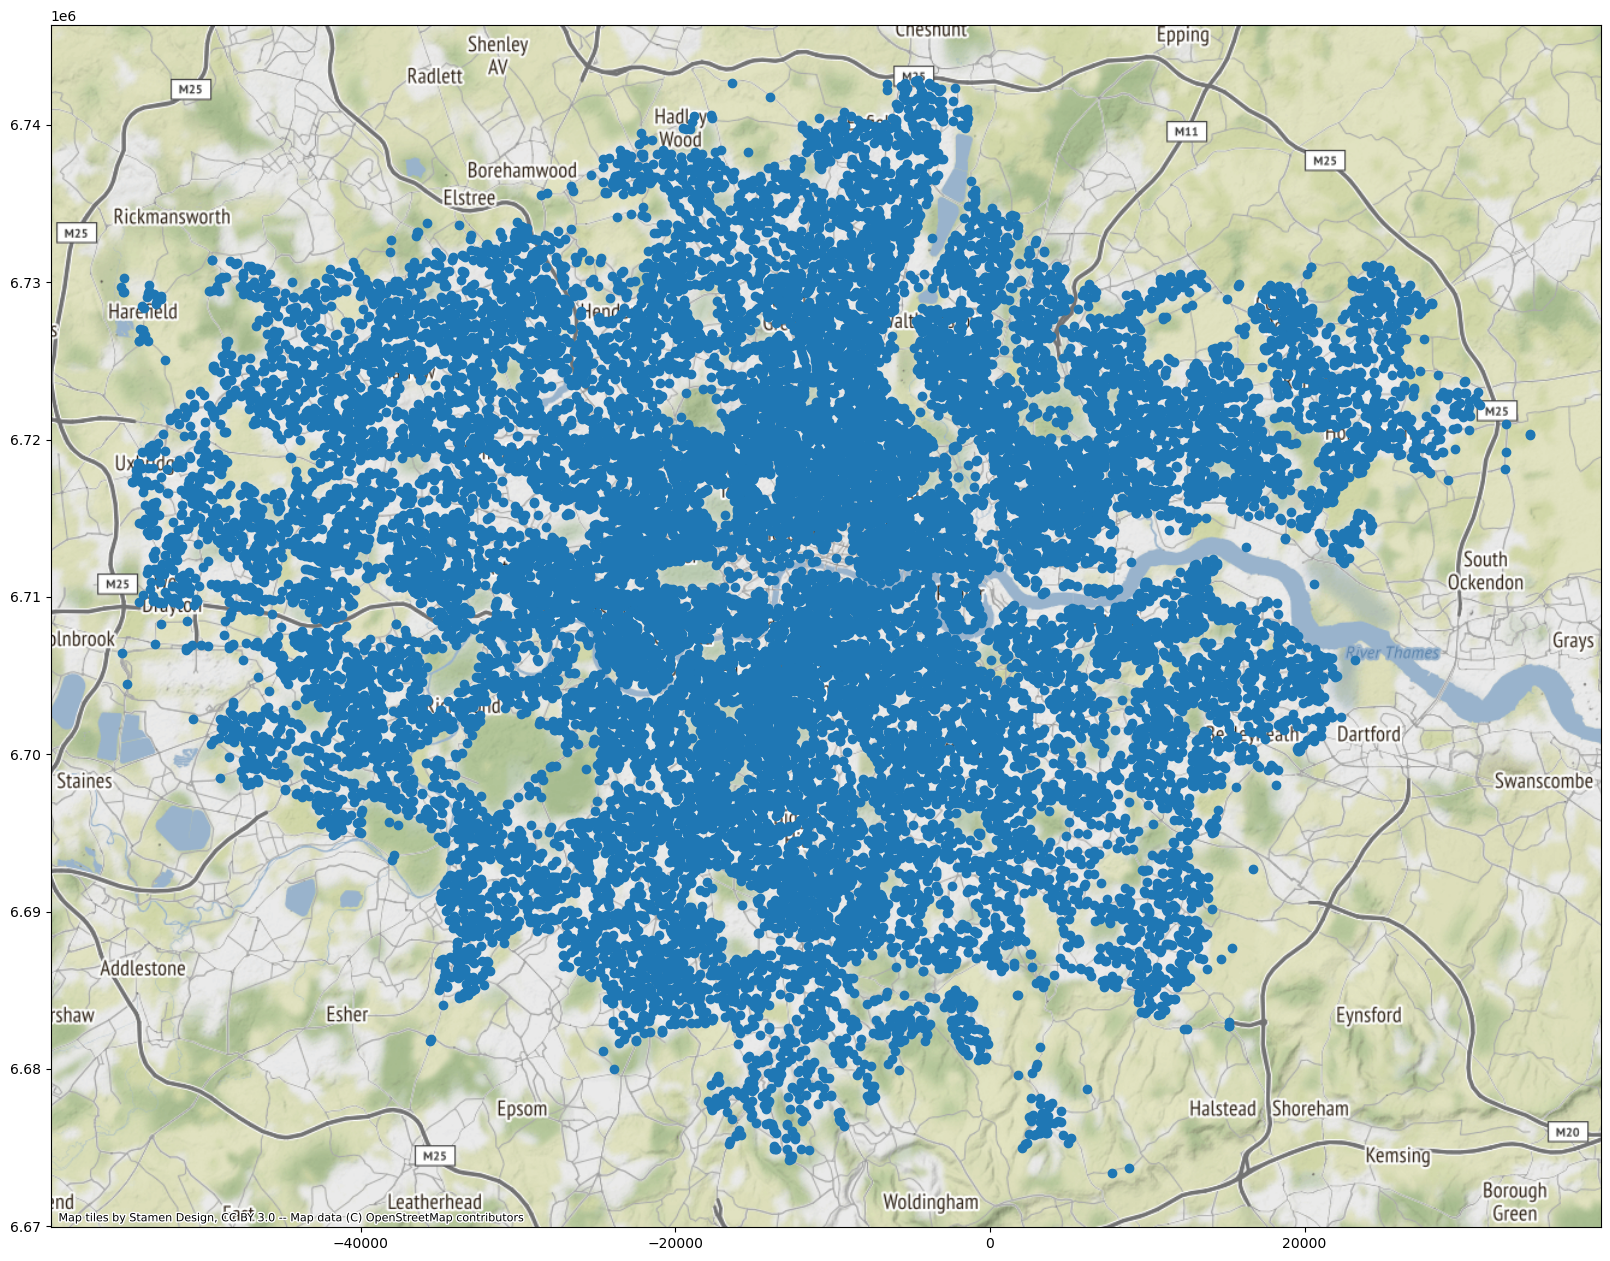

In [48]:
# plot sample points
import contextily as cx
ax = sample_points.plot(figsize=(20,20))
cx.add_basemap(ax, crs=gdf.crs.to_string())

In [49]:
selected_columns = sample_points[['PointID','lat', 'lon', 'index_LSOA', 'LSOA11CD', 'LSOA11NM', 'MSOA11CD', 'MSOA11NM', 'LAD11CD', 'LAD11NM', 'RGN11CD', 'RGN11NM']]

In [50]:
selected_columns.head()

PointID        lat       lon  index_LSOA   LSOA11CD             LSOA11NM  \
0        0  51.515956 -0.095641           0  E01000001  City of London 001A   
1        1  51.517674 -0.096428           0  E01000001  City of London 001A   
2        2  51.515767 -0.095506           0  E01000001  City of London 001A   
3        3  51.520192 -0.097410           0  E01000001  City of London 001A   
4        4  51.517899 -0.097043           0  E01000001  City of London 001A   

    MSOA11CD            MSOA11NM    LAD11CD         LAD11NM    RGN11CD RGN11NM  
0  E02000001  City of London 001  E09000001  City of London  E12000007  London  
1  E02000001  City of London 001  E09000001  City of London  E12000007  London  
2  E02000001  City of London 001  E09000001  City of London  E12000007  London  
3  E02000001  City of London 001  E09000001  City of London  E12000007  London  
4  E02000001  City of London 001  E09000001  City of London  E12000007  London

In [51]:
# save the selected columns
selected_columns.to_csv('all_sample_points.csv', index=False)

In [52]:
selected_columns.shape

(24135, 12)

In [53]:
counts = sample_points.groupby('LSOA11CD').size().sort_values()

# check the number of points in lsoa
for m in range(1,7):
    j=0
    for i in counts:
        if i == m:
            j+=1
    print(f'number of points: {m}, number of lsoa: {j}')

number of points: 1, number of lsoa: 3
number of points: 2, number of lsoa: 2
number of points: 3, number of lsoa: 3
number of points: 4, number of lsoa: 6
number of points: 5, number of lsoa: 4819
number of points: 6, number of lsoa: 0


In [54]:
# check missing value
num_na = sample_points['lat'].isna().sum()
print(f"There are {num_na} missing values in the 'lat' column.")

There are 0 missing values in the 'lat' column.


In [55]:
na_rows = sample_points[sample_points['lat'].isna()]
print(na_rows)

Empty GeoDataFrame
Columns: [PointID, lat, lon, geometry, index_LSOA, LSOA11CD, LSOA11NM, MSOA11CD, MSOA11NM, LAD11CD, LAD11NM, RGN11CD, RGN11NM, USUALRES, HHOLDRES, COMESTRES, POPDEN, HHOLDS, AVHHOLDSZ]
Index: []


# Inner London G

In [10]:
boroughs = ["City of London","Camden", "Greenwich", "Hackney", "Hammersmith and Fulham", 
            "Islington", "Kensington and Chelsea", "Lambeth", "Lewisham",
            "Southwark", "Tower Hamlets", "Wandsworth", "Westminster"]

In [15]:
gdf_innerlondon = gdf2[gdf2['LAD11NM'].isin(boroughs)]

In [17]:
# change crs
gdf_innerlondon = gdf_innerlondon.to_crs(epsg=4326)

In [13]:
# convert graph to geodata
nodes_gdf, edges_gdf = ox.graph_to_gdfs(G_merge)

In [18]:
# cip nodes and edges 
clipped_nodes = gpd.sjoin(nodes_gdf, gdf_innerlondon, how="inner", op="within")
clipped_edges = gpd.sjoin(edges_gdf, gdf_innerlondon, how="inner", op="within")

C:\Users\win10\.conda\envs\yyjj125\lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
C:\Users\win10\.conda\envs\yyjj125\lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [20]:
# convert geodata to graph
G_clip = ox.graph_from_gdfs(clipped_nodes, clipped_edges)

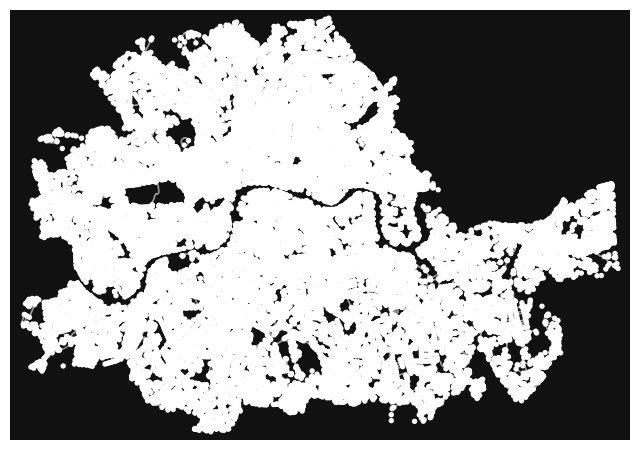

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [21]:
# plot
ox.plot_graph(G_clip)

In [22]:
# check number of edges
num_edges = len(G_clip.edges())
print(f'Number of edges after clipping: {num_edges}')

Number of edges after clipping: 64484


In [ ]:
# I acknowledge the use of ChatGPT 4.0 (Open AI, https://chat.openai.com) to debug.